<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data loading</a></span></li><li><span><a href="#Distribution-of-classes" data-toc-modified-id="Distribution-of-classes-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Distribution of classes</a></span></li><li><span><a href="#Splitting-the-training-and-test-datasets" data-toc-modified-id="Splitting-the-training-and-test-datasets-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Splitting the training and test datasets</a></span></li></ul></li><li><span><a href="#Training-and-finding-the-best-model-using-pipelines" data-toc-modified-id="Training-and-finding-the-best-model-using-pipelines-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training and finding the best model using pipelines</a></span><ul class="toc-item"><li><span><a href="#Evaluating-the-best-model-on-the-test-set" data-toc-modified-id="Evaluating-the-best-model-on-the-test-set-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Evaluating the best model on the test set</a></span></li></ul></li><li><span><a href="#Cross-checking-with-a-dummy-model" data-toc-modified-id="Cross-checking-with-a-dummy-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cross-checking with a dummy model</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Identifying Toxic Comments on an E-Commerce Platform with BERT

The e-commerce platform is launching a new service that allows users to edit and enhance product descriptions, similar to wiki communities. Users can propose their own edits and comment on others' changes. The store needs a tool to detect toxic comments and send them for moderation.

**Objective:** Train a model to classify comments as positive or negative with a quality metric F1 score of at least 0.75.

**Data Description**

The data is located in the file `toxic_comments.csv`. The text column contains the comment text, and the toxic column is the target variable.

Let's load necessary libraries, data, and auxiliary functions/classes.

In [1]:
import os
import numpy as np
import pandas as pd
import re

from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('english'))


from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer



from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection  import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings("ignore")

from helper_functions import importdata

## Data Preparation

### Data loading

In [2]:
filedirs = ['../datasets/']
fname = 'toxic_comments.csv'
fixed_seed = 72 
df_tweets = importdata(filedirs,fname).sample(frac=0.001, random_state=fixed_seed).reset_index(drop=True)

File toxic_comments.csv is loaded from ../datasets/


Let's go over the general information.

In [3]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  159 non-null    int64 
 1   text        159 non-null    object
 2   toxic       159 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.9+ KB


In [4]:
display(df_tweets.head())

,Unnamed: 0,text,toxic
0,45284,It is not according to MEDRS. Are you saying t...,0
1,129102,""", 5 April 2009 (UTC)\nIf he was born and rais...",0
2,74447,"""\n\n''The above discussion is preserved as an...",0
3,17964,Hi there. Let me make my comment a little mor...,0
4,78916,[{unblock|responding administrators don't have...,0


There are no missing values in the fields, and the data types are properly defined.

The 'Unnamed: 0' column doesn't provide any useful information.

In [5]:
df_tweets.drop('Unnamed: 0',axis=1,inplace=True)

We'll remove any unnecessary characters from the descriptions. 

In [6]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    tmp = text.split()
    return " ".join(tmp)

df_tweets.insert(2,'reg_text','')

df_tweets['reg_text'] = df_tweets['text'].apply(clear_text)
display(df_tweets.head())

,text,toxic,reg_text
0,It is not according to MEDRS. Are you saying t...,0,it is not according to medrs are you saying th...
1,""", 5 April 2009 (UTC)\nIf he was born and rais...",0,april utc if he was born and raised in austral...
2,"""\n\n''The above discussion is preserved as an...",0,the above discussion is preserved as an archiv...
3,Hi there. Let me make my comment a little mor...,0,hi there let me make my comment a little more ...
4,[{unblock|responding administrators don't have...,0,unblock responding administrators don t have a...


In [7]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV,
               }
    return tag_dict.get(tag, wordnet.NOUN)

Next, we will lemmatize the tweets.

In [8]:
m = WordNetLemmatizer()
def lemmatize(text):
    
    lemm_list = [m.lemmatize(w,get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    lemm_text = " ".join(lemm_list)
        
    return lemm_text

df_tweets.insert(3,'lemm_text','')

df_tweets['lemm_text'] = df_tweets['reg_text'].apply(lemmatize)
display(df_tweets.head())

,text,toxic,reg_text,lemm_text
0,It is not according to MEDRS. Are you saying t...,0,it is not according to medrs are you saying th...,it be not accord to medrs be you say that le v...
1,""", 5 April 2009 (UTC)\nIf he was born and rais...",0,april utc if he was born and raised in austral...,april utc if he be born and raise in australia...
2,"""\n\n''The above discussion is preserved as an...",0,the above discussion is preserved as an archiv...,the above discussion be preserve a an archive ...
3,Hi there. Let me make my comment a little mor...,0,hi there let me make my comment a little more ...,hi there let me make my comment a little more ...
4,[{unblock|responding administrators don't have...,0,unblock responding administrators don t have a...,unblock respond administrator don t have a sol...


Let's take one description and observe how it evolves through the transformations. 

In [9]:
df_tweets['text'][0]

"It is not according to MEDRS. Are you saying that Les Vegas' wording over-generalizes its findings?"

The original sentence contains special characters and numbers. We'll check how it looks after filtering irregular expressions.

In [10]:
df_tweets['reg_text'][0]

'it is not according to medrs are you saying that les vegas wording over generalizes its findings'

 The unnecessary characters are gone. Now, let's review how the parts of speech are identified.

In [11]:
m = WordNetLemmatizer()
text = df_tweets['reg_text'][0]
[m.lemmatize(w,get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
for w in nltk.word_tokenize(text):
    print(w,get_wordnet_pos(w))

it n
is v
not r
according v
to n
medrs n
are v
you n
saying v
that n
les n
vegas n
wording v
over n
generalizes n
its n
findings n


Most parts of speech are correctly recognized, though not all of them.

In [12]:
df_tweets['lemm_text'][0]

'it be not accord to medrs be you say that le vega word over generalizes it finding'

We can see that some words are converted to their base forms, for example, "is" goes to "be."

Identifying parts of speech and lemmatizing takes considerable time. Therefore, I’ve prepared a separate file to avoid repeating this process in Jupyter cells.

In [13]:
df_tweets_lemm = importdata(filedirs,'toxic_comments_lemm.csv')

File toxic_comments_lemm.csv is loaded from ../datasets/


In [14]:
df_tweets_lemm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
 3   reg_text    159281 non-null  object
 4   lemm_text   159281 non-null  object
dtypes: int64(2), object(3)
memory usage: 6.1+ MB


In [15]:
df_tweets_lemm.dropna(inplace=True)
print(df_tweets_lemm.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159281 entries, 0 to 159291
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159281 non-null  int64 
 1   text        159281 non-null  object
 2   toxic       159281 non-null  int64 
 3   reg_text    159281 non-null  object
 4   lemm_text   159281 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.3+ MB
None


### Distribution of classes

We observe no undeclared classes

In [16]:
df_tweets_lemm['toxic'].unique()

array([0, 1], dtype=int64)

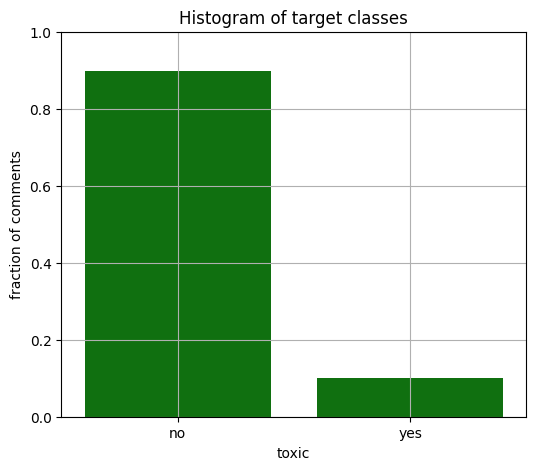

In [17]:
y = 'toxic' 
fig, ax = plt.subplots(1, 1,figsize=(6,5))

sns.countplot(df_tweets_lemm,x=y, ax=ax,
             color='green',stat='proportion')

ax.set_xticks([0,1],['no', 'yes'])

ax.set_xlabel(y)
ax.tick_params(axis='x')
ax.set_ylabel('fraction of comments')
ax.set_ylim(0,1)
ax.grid()
plt.title('Histogram of target classes')
plt.show()

The histogram for the target values shows that the two classes are imbalanced, with around 10% of toxic tweets. 

Finally, we'll drop any duplicates, if they are any.

In [18]:
num_dupl = df_tweets_lemm[['lemm_text','toxic']].duplicated().sum()
if num_dupl>0:
    df_tweets_lemm.drop_duplicates(subset=['lemm_text','toxic'],inplace=True)
    print(f'Dropping {num_dupl} duplicates')

Dropping 1303 duplicates


### Splitting the training and test datasets

We'll reserve 25% of the data for the test set.

In [19]:
X = df_tweets_lemm['lemm_text']
y = df_tweets_lemm['toxic']
X_train_corpus, X_test_corpus, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42)

## Training and finding the best model using pipelines

We'll start by 
* applying a linear logistic regression model,
* using cross-validation,
* the best model will be determined based on the F1 score metric.

We'll configure the TfidfVectorizer class to compute the TF-IDF for the text in both the training and test sets, considering stop words and identifying N-grams in the range from 1 to 5.

Since not all features may contribute, we'll apply regularization to the linear logistic regression model. 

In [20]:
estimators = [("tf_idf", TfidfVectorizer(stop_words="english",lowercase=True,max_features=18244)), 
              ("lr", LogisticRegression())         
             ]
model = Pipeline(estimators)

params = {
         "lr__C":[1, 10, 100
                        ], #regularization parameter
          "tf_idf__ngram_range": [(1,1), (1,2), (1,5)], #1-2-grams or 1-5-grams

}
grid = RandomizedSearchCV(
     estimator=model
    ,param_distributions = params
    ,n_jobs = -1
    ,n_iter=9
    ,refit=True
    ,random_state=fixed_seed
    , cv=2
)
grid.fit(X_train_corpus, y_train)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('tf_idf',
                                              TfidfVectorizer(max_features=18244,
                                                              stop_words='english')),
                                             ('lr', LogisticRegression())]),
                   n_iter=9, n_jobs=-1,
                   param_distributions={'lr__C': [1, 10, 100],
                                        'tf_idf__ngram_range': [(1, 1), (1, 2),
                                                                (1, 5)]},
                   random_state=72)

The best model has the follwing hyperparameters:

In [21]:
grid.best_params_

{'tf_idf__ngram_range': (1, 1), 'lr__C': 10}

Turns out, the regularization is useful.

### Evaluating the best model on the test set

In [22]:
 y_pred = grid.best_estimator_.predict(X_train_corpus)
print('f1 on the train set, logistic regression', f1_score(y_train,y_pred))

y_pred = grid.best_estimator_.predict(X_test_corpus)
test_score = f1_score(y_test,y_pred)
print('f1 on the test set, logistic regression', test_score)

f1 on the train set, logistic regression 0.8514537125232458
f1 on the test set, logistic regression 0.7765883497845127


We barely surpassed the F1 score threshold of 0.75, achieving an F1 score of 0.78. 

## Cross-checking with a dummy model 

In [23]:
dummy_class = DummyClassifier(strategy="uniform",random_state=fixed_seed)
X_train_dummy = grid.best_estimator_.steps[0][1].fit_transform(X_train_corpus)
X_test_dummy = grid.best_estimator_.steps[0][1].transform(X_test_corpus)

dummy_class.fit(X_train_dummy, y_train)
y_dummy_pred = dummy_class.predict(X_test_dummy)
dummy_test_score = f1_score(y_test,y_dummy_pred)

print('On the test set')
print(f'F1 metric, dummy model'
      f' {dummy_test_score:.1f}')
print(f'F1 metric of the best model is '
      f' {round((test_score/dummy_test_score),1):.1f} times better than the dummy model.')

On the test set
F1 metric, dummy model 0.2
F1 metric of the best model is  4.6 times better than the dummy model.


 When the target class is selected randomly, the ridge linear regression model with weighting offers a significant advantage.

## Conclusion

We trained a linear logistic regression (ridge regression) model using the data from the online store, which consists of product descriptions labeled for toxicity. Before training, we removed irregular expressions, lemmatized the text, and used 1-, 2-, ..., 5-grams. For training, we reserved 25% of the original data as the test set.

* The model with a regularization parameter of $C=10$ and a 1-gram approach performed best at identifying both toxic and non-toxic descriptions. The F1 score on the test set is 0.77.

* Additionally, the logistic regression model significantly outperformed a model that predicts toxicity/non-toxicity randomly.